In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('../src_jobs/')

In [2]:
import pickle
from itertools import repeat
from pathlib import Path
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import torch
from artifact import Saw_centered
from detector import SlidingWindowTransformerDetector

from data import CachedArtifactDataset, TestArtifactDataset, CenteredArtifactDataset

/opt/miniconda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.set_grad_enabled(False)

In [4]:
rng = np.random.default_rng()
rng.choice(2)

0

In [5]:
test_width = 512

val = Path("/workspaces/AICoE_Ramping_Artefacts/artifactory-master/data/validation_slidingWindow_512.pkl")

In [6]:
val = CachedArtifactDataset(file=val)
len(val[0]['artifact'])

512

In [7]:
ground_truth = pd.read_csv('/workspaces/AICoE_Ramping_Artefacts/artifactory-master/data/gt_slidingWindow_realData.csv')

test_width = 512
dist = test_width // 2
start_ind = 13100 + dist
end_ind = 147000 - dist

In [8]:
ground_truth = ground_truth["0"][start_ind : end_ind]
grouped = ground_truth.groupby(ground_truth)

negatives = grouped.get_group(0.0)
positives = grouped.get_group(1.0)

In [9]:
negatives_selection = negatives.sample(n=len(positives))

test_set_real = pd.concat([positives, negatives_selection])

shuffled_test_set = test_set_real.sample(frac=1)

In [10]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

#autheticate
credential = DefaultAzureCredential()

# Get a handle to the workspace
ml_client = MLClient.from_config(
    credential=credential,
    path="config.json",
)

Found the config file in: config.json


In [11]:
import azure.ai.ml._artifacts._artifact_utilities as artifact_utils

data_asset = ml_client.data.get("output_Train_GPU_slidingWindow", version="1")
artifact_utils.download_artifact_from_aml_uri(uri=data_asset.path, destination="./checkpoints_transformer/", datastore_operation=ml_client.datastores)
transformer_detector = SlidingWindowTransformerDetector.load_from_checkpoint("/workspaces/AICoE_Ramping_Artefacts/artifactory-master/notebooks/checkpoints_transformer/epoch=0-step=30000-v1.ckpt").cpu()

TypeError: SlidingWindowTransformerDetector.__init__() missing 1 required positional argument: 'pooling'

In [ ]:
real_data_df = pd.read_pickle('/workspaces/AICoE_Ramping_Artefacts/artifactory-master/data/real/normalized_deviation_updated_TEST.pickle') 

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, confusion_matrix, roc_curve

preds_trans = list()
gt = list()

for center in shuffled_test_set.index:
    example = torch.tensor(real_data_df[0][center-dist : center+dist])
    length  = len(example)

    prediction_trans = transformer_detector(example.unsqueeze(0))

    preds_trans = preds_trans + [prediction_trans.numpy()]
    gt = gt + [shuffled_test_set[center]]

In [15]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(gt, preds_trans)
J = precision + recall
ix = np.argmax(J)
best_thresh_pr = thresholds[ix]

Text(0.5, 1.0, 'Validation Precision-Recall curve')

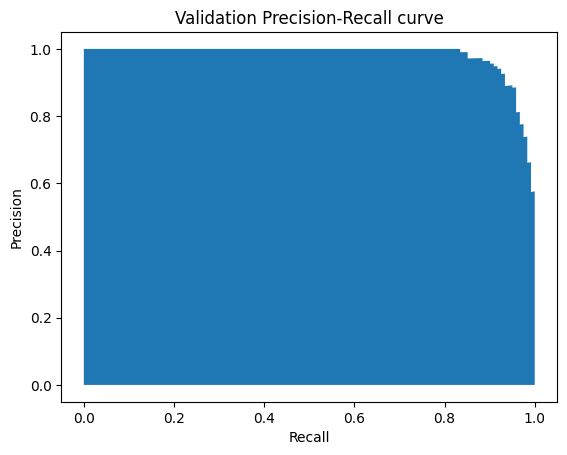

In [16]:
import matplotlib.pyplot as plt

plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Validation Precision-Recall curve")

In [17]:
threshold = best_thresh_pr

preds_binary = [1 if value >= threshold else 0 for value in preds_trans]
tn_trans, fp_trans, fn_trans, tp_trans = confusion_matrix(gt, preds_binary, labels=[0, 1]).ravel()

metrics = pd.DataFrame([{
    'detector': 'slidingWindow_transformer',
    'accuracy': accuracy_score(gt, preds_binary),
    'precision': precision_score(gt, preds_binary),
    'recall': recall_score(gt, preds_binary),
    'mse': mean_squared_error(gt, preds_binary),
    'tn': tn_trans,
    'fp': fp_trans, 
    'fn': fn_trans, 
    'tp': tp_trans
}])

In [18]:
metrics

,detector,accuracy,precision,recall,mse,tn,fp,fn,tp
0,slidingWindow_transformer,0.933884,0.941176,0.92562,0.066116,114,7,9,112


In [19]:
df = pd.DataFrame({
    'index': shuffled_test_set.index.to_list(),
    'gt': shuffled_test_set.values,
    'predictions': preds_binary
})

In [20]:
# get false positives
fp_ind = (df.loc[(df['gt'] == 0) & (df['predictions'] == 1)])["index"]
fn_ind = (df.loc[(df['gt'] == 1) & (df['predictions'] == 0)])["index"]
tn_ind = (df.loc[(df['gt'] == 0) & (df['predictions'] == 0)])["index"]
tp_ind = (df.loc[(df['gt'] == 1) & (df['predictions'] == 1)])["index"]

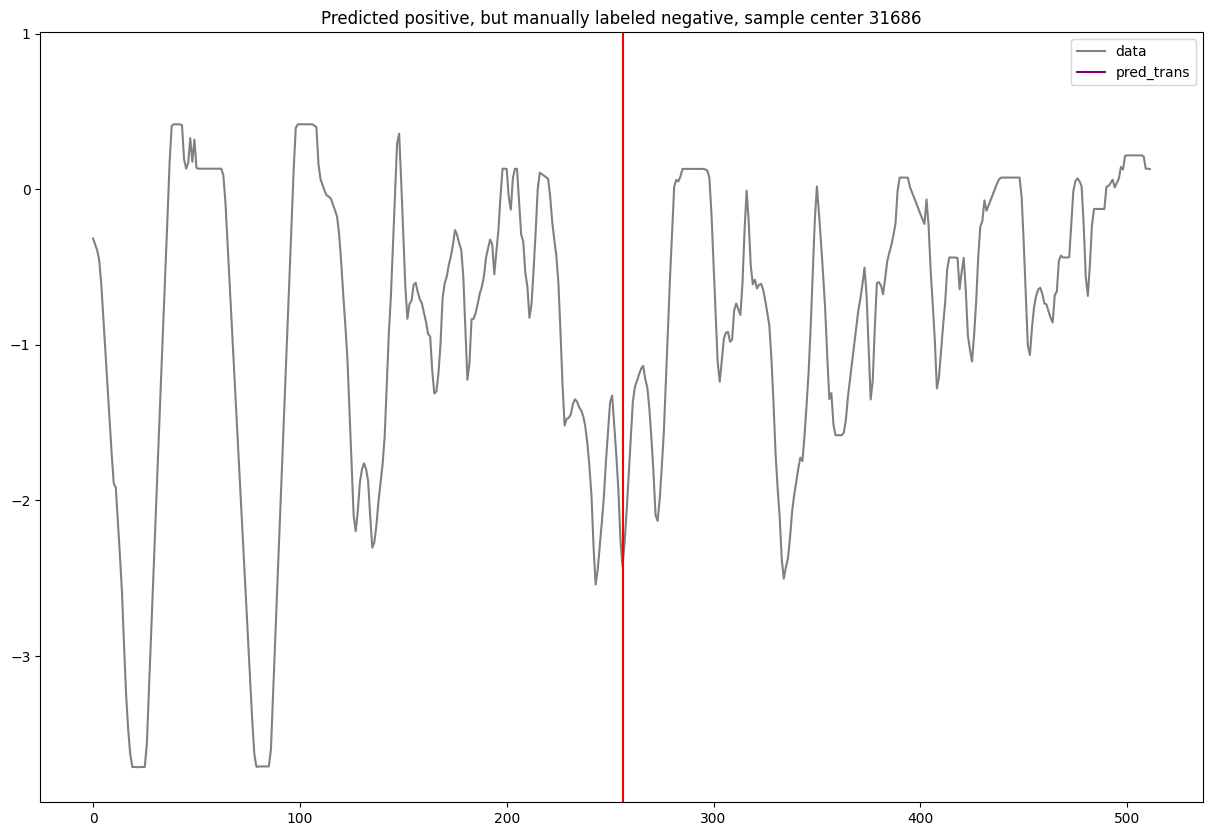

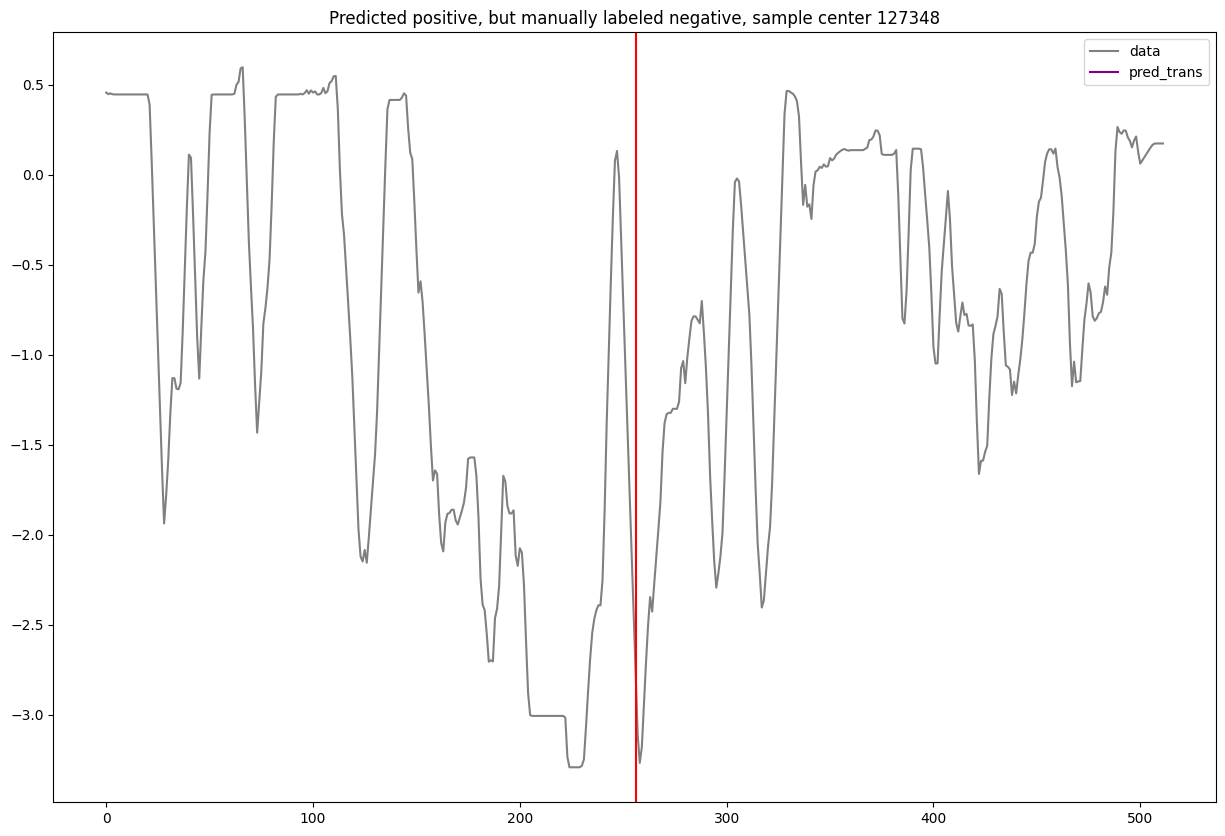

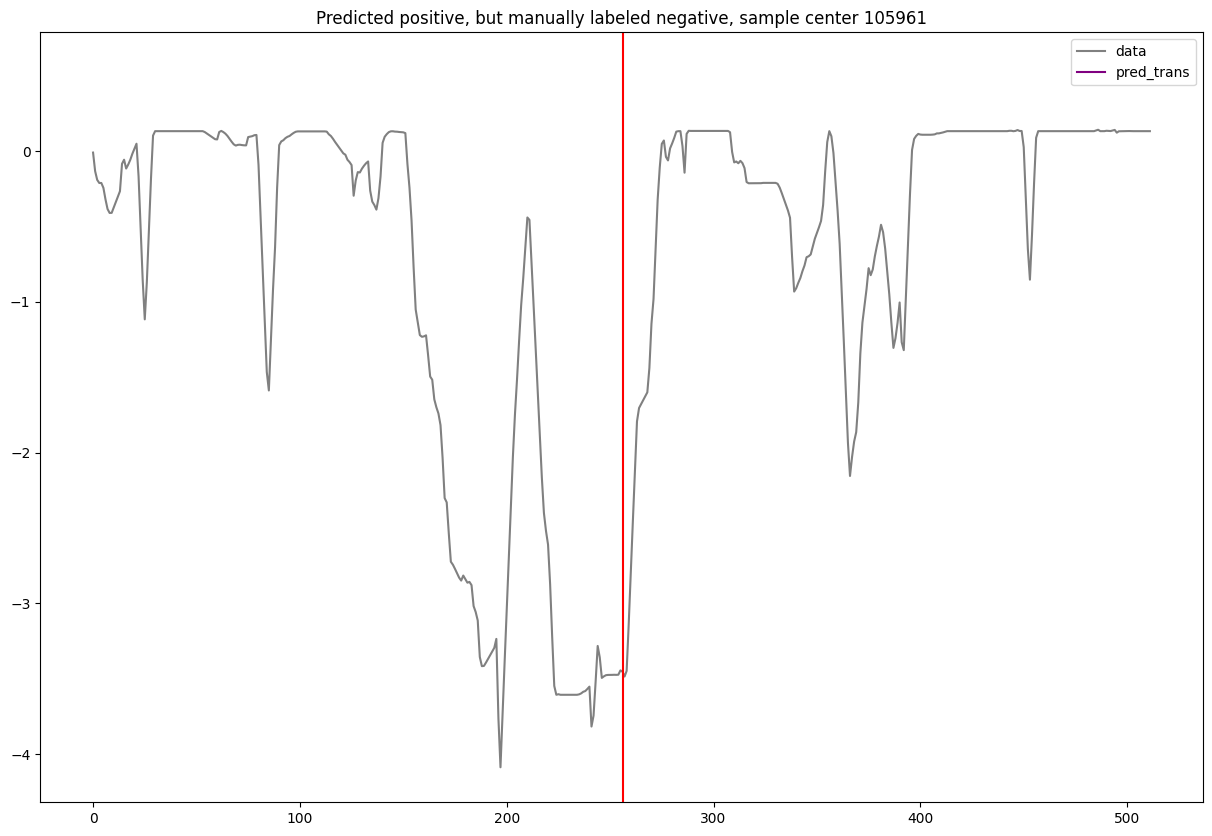

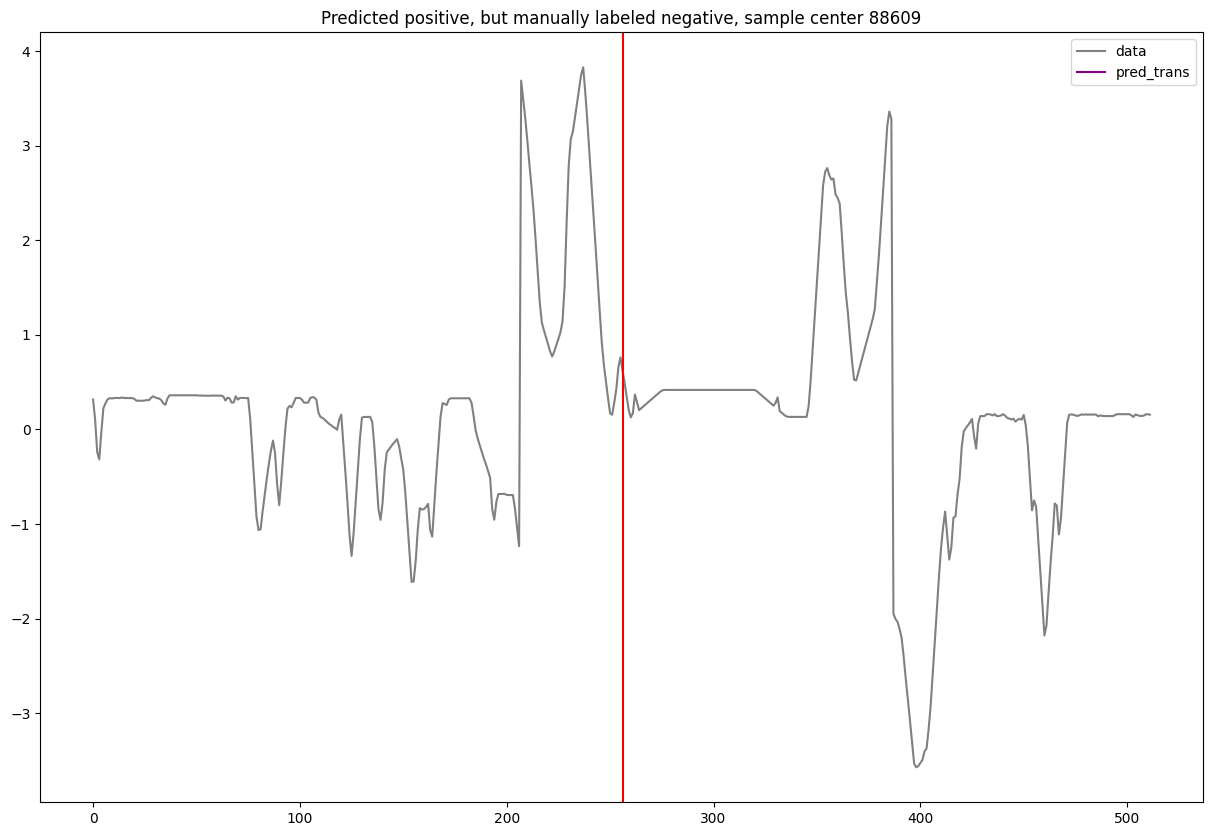

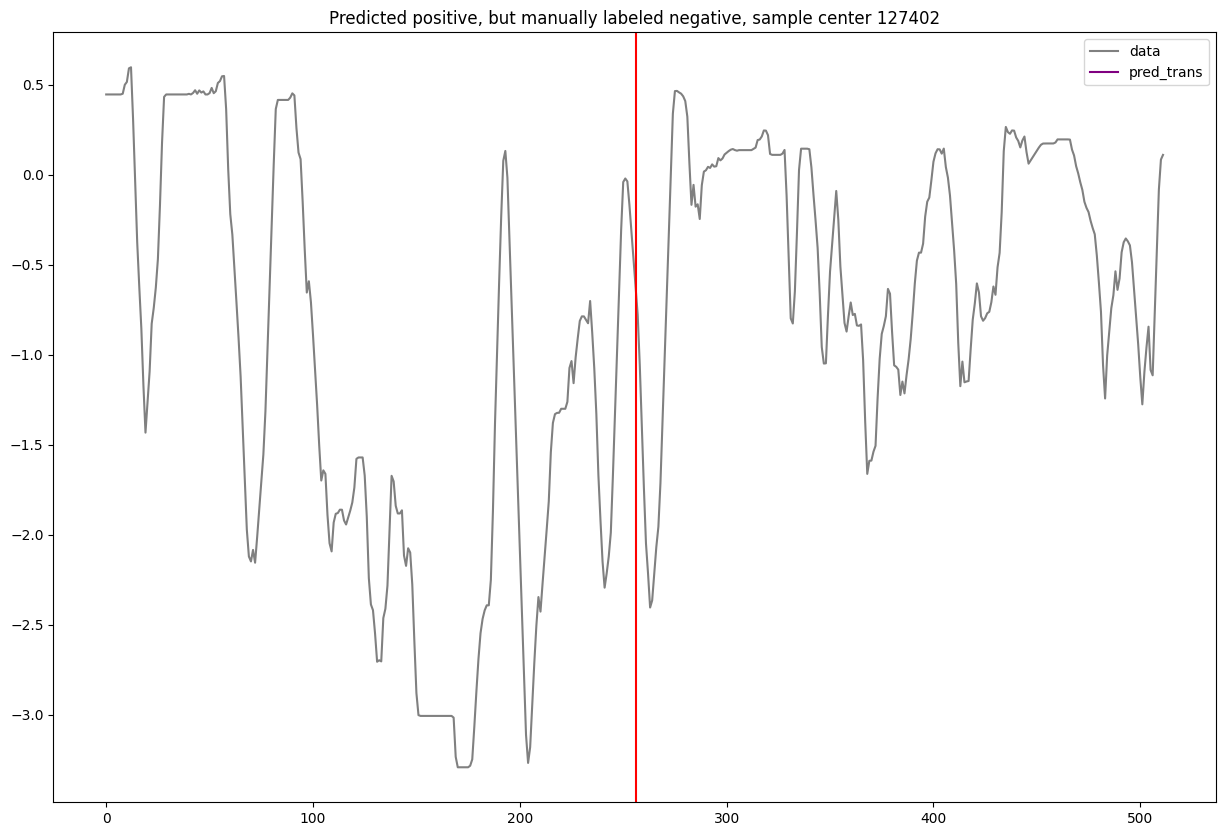

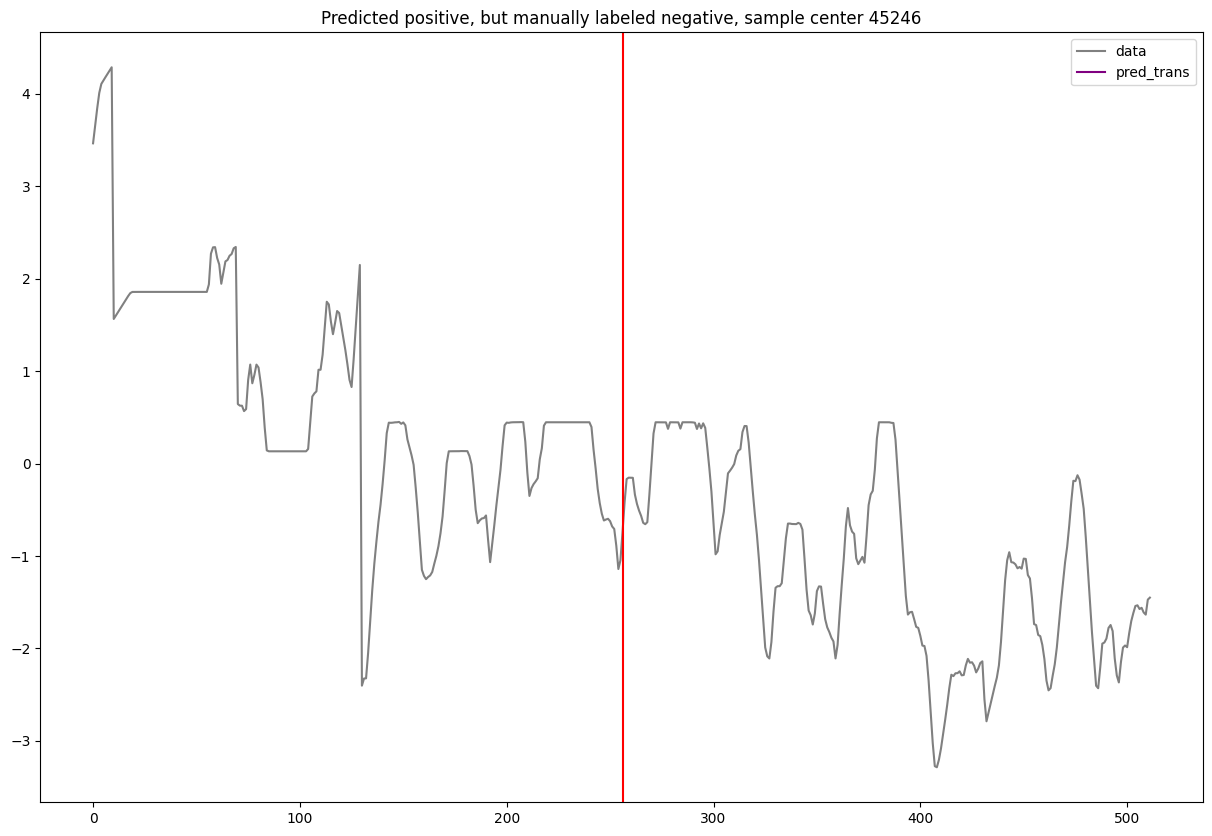

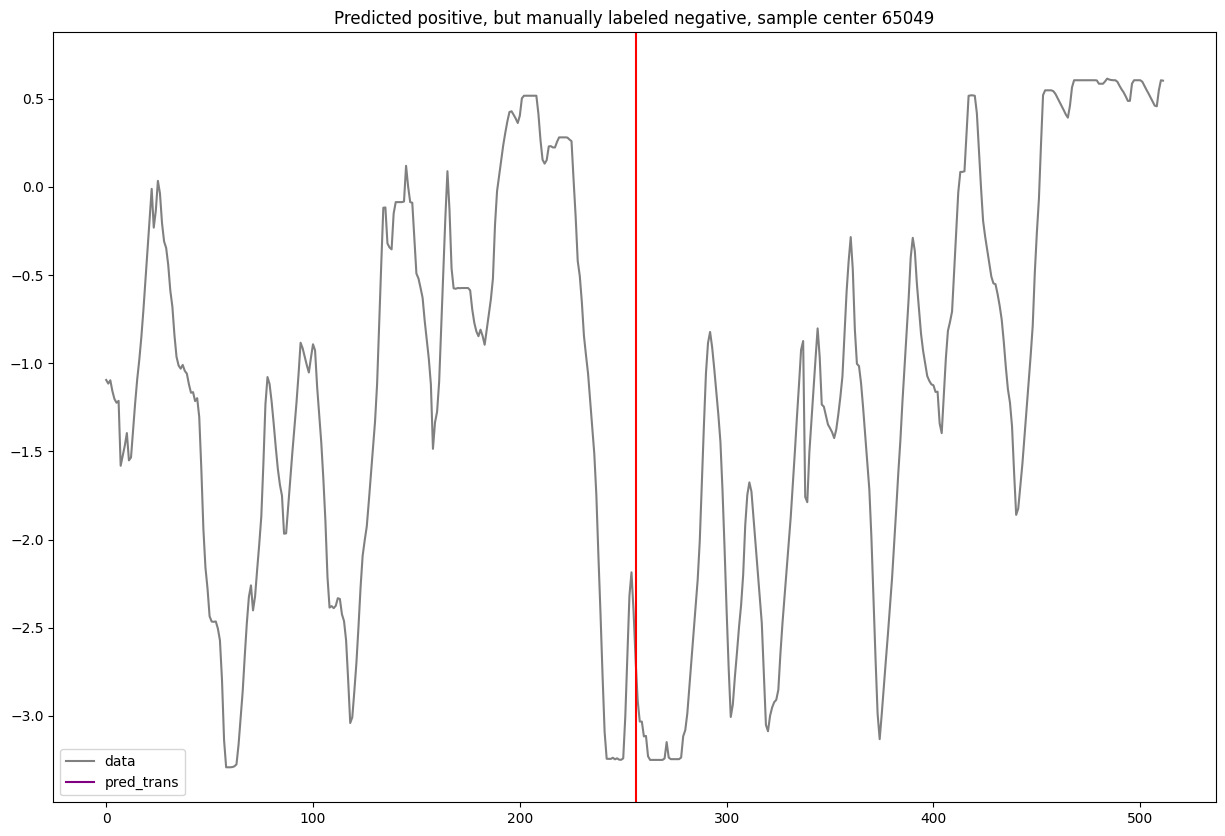

In [21]:
for index in fp_ind:
    example = torch.tensor(real_data_df[0][index-dist : index+dist])
    length  = len(example)

    prediction_trans = transformer_detector(example.unsqueeze(0))

    plt.figure(figsize=(15, 10))
    plt.plot(example, label="data", c="grey")
    plt.axvline(x=256, c="red")
    plt.plot(prediction_trans, label="pred_trans", c="purple")
    plt.title(f"Predicted positive, but manually labeled negative, sample center {int(index)}")
    plt.legend()
    plt.show()